# Analysis for actin changes in epithelial wounds

Goal: Be able to quantify the amount of actin staining at the wound edge with the cell edges of subsequent cell fronts.

# Step 1 - Import data

CSVs are created ahead of time using "Plot Profile" from FIJI. Data are in alternating columns of distance, intensity. There will be at least four "profiles" per wound. 

example file for me: /Users/elizabeth/Desktop/sample data.csv

Apyrase path: /Users/elizabeth/Desktop/Apyrase phalliodin/analysis/input excel/Apyrase 10 min/

Control path: /Users/elizabeth/Desktop/Apyrase phalliodin/analysis/input excel/Control 10 min/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.stats import linregress
from scipy import ndimage
import tkinter as tk
from tkinter import filedialog

# upload sample data
#filename = input("Please enter location and filename:")

# create a Tkinter root window
root = tk.Tk()

# hide the root window
root.withdraw()

# prompt the user to select a CSV file
file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
print(file_path)

#load data to pandas dataframe
#if headers already in file, remove "header=None,"
bdf1 = pd.read_csv(file_path, header=None, encoding='utf-8')

#To make all the data the same length
bdf = bdf1.dropna()
print(bdf)

/Users/elizabeth/Desktop/Apyrase phalliodin/analysis/rep intact control j2 232981.csv
            0        1
0       0.000  478.000
1       0.227  509.960
2       0.454  536.623
3       0.680  500.978
4       0.907  506.058
...       ...      ...
1100  249.433  457.493
1101  249.660  471.413
1102  249.887  459.420
1103  250.113  475.938
1104  250.340  503.000

[1105 rows x 2 columns]


In [2]:
# Extract alternating columns of distance and intensity
#This is just for me to know how to get alternating columns
distances = bdf.iloc[:, 0::2]
intensities = bdf.iloc[:, 1::2]

In [3]:
#Add Column names 

#create column names based on number of columns
c = len(bdf.columns)
colnum = int(c/2)

col_dlist = ['distance' + str(x) for x in range(1,colnum+1)]

col_ilist = ['intensity' + str(x) for x in range(1,colnum+1)]


#alternate appending names
col = []
for x, y in list(zip(col_dlist, col_ilist)):
    col.append(x)
    col.append(y)
    
#change list to an array
#colnam = np.array(col)

#add headers
bdf.columns = col

## Step 1.5 - Quick Plot Check 
This is to make sure the data has plotted corrected with correct column names

      distance1  intensity1
0         0.000     478.000
1         0.227     509.960
2         0.454     536.623
3         0.680     500.978
4         0.907     506.058
...         ...         ...
1100    249.433     457.493
1101    249.660     471.413
1102    249.887     459.420
1103    250.113     475.938
1104    250.340     503.000

[1105 rows x 2 columns]


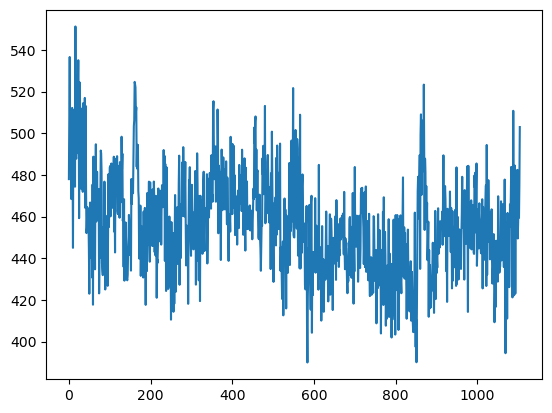

In [4]:
print(bdf)
plt.plot(bdf.iloc[:,1::2])

# Step 2 - Baseline
The goal of this section is to choose a type of baseline: flat or sloped or this fancy "Asymmetric Least Squares Smoothing". Currently there is only a flat baseline option. More to come later? Now there is a sloping baseline that is done using linear regression.

In [5]:
#This is basic flat baseline
#blflat = int(input("Please enter distance range for a flat baseline:"))


#baseline = bdf.iloc[(bdf['distance1'] <= blflat)]

#by = baseline.iloc[:, 1::2].mean()

#norm = bdf.iloc[:, 1::2].subtract(by)
#bdf.iloc[:, 1::2] = norm


In [6]:
# Generate a sloping baseline for each column of data, here you can just change the slope manually. This was dumb
#x = bdf['distance1']
#baselines = -.5 * x.values.reshape(-1, 1)  # reshape x to a column vector
#df_with_baselines = bdf.add(baselines.flatten(), axis=0)


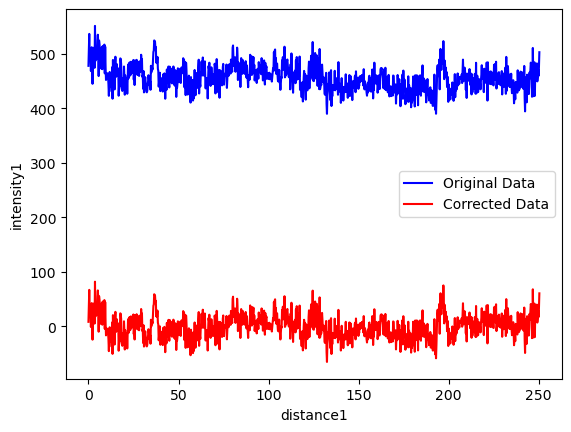

In [7]:
# Create a new DataFrame to hold the corrected data
corrected_data = pd.DataFrame()

# Loop through the columns in the DataFrame (assuming that they alternate between x and y data)
for i in range(0, len(bdf.columns), 2):

    # Extract the independent variable column and the dependent variable column
    x_col = bdf.columns[i]
    y_col = bdf.columns[i+1]
    x = bdf[x_col]
    y = bdf[y_col]

    # Calculate the slope and intercept of the regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Create a sloping baseline using the slope and intercept values
    baseline = slope * x + intercept

    # Subtract the baseline from the dependent variable column values to create the corrected data
    corrected_y = y - baseline
    
    # Add the corrected y data to the corrected_data DataFrame
    corrected_data[y_col] = corrected_y
    
    # Create a plot with the original data in blue and the corrected data in red
    plt.plot(x, y, 'b-', label='Original Data')
    plt.plot(x, corrected_y, 'r-', label='Corrected Data')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.show()
    

# Add the independent variable data (assuming that they are the same for all columns) to the corrected_data DataFrame
#corrected_data[x_col] = x


    

In [8]:
print(corrected_data)

      intensity1
0       8.100058
1      40.084799
2      66.772540
3      31.152172
4      36.256913
...          ...
1100   14.778999
1101   28.723740
1102   16.755481
1103   33.298112
1104   60.384853

[1105 rows x 1 columns]


## Step 2.5 - Quick Plot Check
This is to make sure that the baseline looks good. Hopefully later I add a step to accept or reject the baseline.


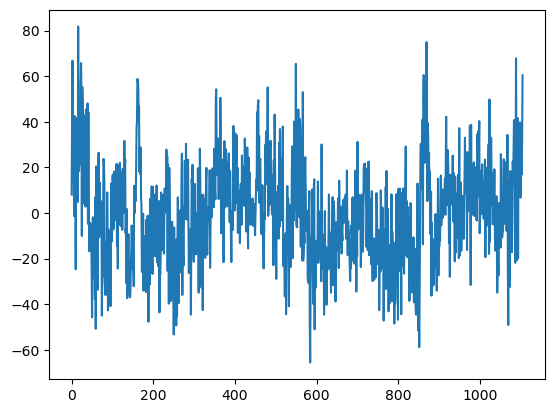

In [9]:
#This is the plot of the baselined data
#plt.plot(bdf.iloc[:, 1::2])
plt.plot(corrected_data)
plt.show()

# Step 3 - Determine Maxima
The goal of this section is to get the local maxima, which should correspond to intensities the lamellipodia.


2
1105
(1105, 1)
(1105, 2)


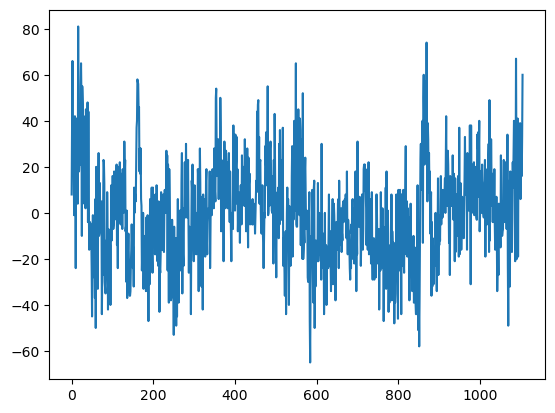

In [10]:
#argrelextrema cannot use floats so this code changes the baselined dataframe into an array by:
#1) removing the nans
#2) switching the floats to int

bdf_nonan = np.nan_to_num(corrected_data, nan=0)
bdf_int = bdf_nonan.astype(int)


print(bdf_int.ndim)
print(bdf_int.size)
print(bdf_int.shape)


plt.plot(bdf_int)
print(bdf.shape)



What number of points do you want to check before and after?:100
      intensity1
16     81.770477
161    58.746100
354    54.239980
549    65.375342
700    31.212192
869    74.931944
1088   67.786434


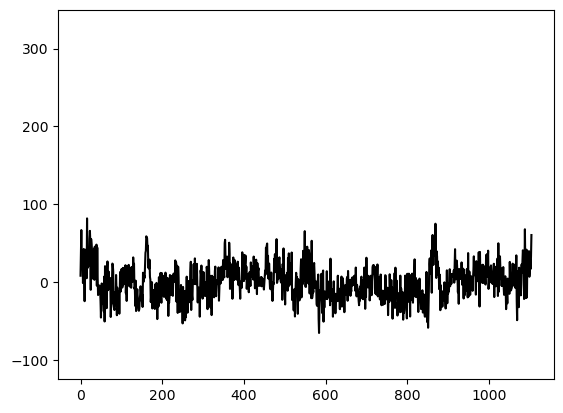

In [ ]:
redo = True
while redo:

    #number of points to be checked before and after, this is the range of finding local maxima
    maxrange = int(input("What number of points do you want to check before and after?:"))

    #This loops through each column of the new baselined data, corrected_data
    #1) extract the underlying numpy array of that column using the .values method and store it in col_data
    #2) argrelextrema to find the indices of the local maxima in col_data and store them in maxima_indices
    #3) then use these indices to extract the local maxima values from col_data and store them in maxima_values
    #4) create a pandas Series maxima_col using maxima_values, with the name of the Series set to the name of the column col and the index set to maxima_indices.
    #5) concatenate the maxima_col Series to the maxima_df DataFrame along the column axis (axis=1). 
    #Maxima_df will contain the local maxima values for each column of corrected_data.
    maxima_df = pd.DataFrame()

    for col in corrected_data.columns:
        col_data = corrected_data[col].values
        maxima_indices = argrelextrema(col_data, np.greater_equal, order=maxrange)[0]
        maxima_values = col_data[maxima_indices]
        maxima_col = pd.Series(maxima_values, name=col, index=maxima_indices)
        maxima_df = pd.concat([maxima_df, maxima_col], axis=1)
    
    
    print(maxima_df)    
    plt.plot(corrected_data, color='black')
    plt.ylim([-125, 350])
    #plt.xlabel('Pixels')
    #plt.ylabel('Intensity')
    #fig, ax = plt.subplots()
    #ax.plot(x, y, color='black')
    #ax.set_xlabel('Pixels')
    #ax.set_ylabel('Intensity')
        # add inset axes
    #inset_ax = fig.add_axes([0.55, 0.6, 0.3, 0.3])  
    # position and size of the inset axes
    #inset_ax.plot(x, y, color='red')
    #inset_ax.set_xlabel('Pixels')
    #inset_ax.set_ylabel('Intensity')


    #loop through each column and create a scatter plot
    #for col in maxima_df.columns:
            #plt.scatter(maxima_df.index, maxima_df[col],color='black', s=100)

    plt.show()

#prompt the user to enter yes or no to proceed or redo the box
    response = input("Do you want to proceed with these settings? (yes/no)")
    if response.lower() == "yes":
        redo = False
    elif response.lower() == "no":
        redo = True
    else:
        print("Invalid input. Please enter either 'yes' or 'no'.")


## Step 3.5 - Quick Plot Check
This is to see if the maxima we found actually correspond to the correct points. I still need to figure out how ot plot the maxima as dots and not these janky lines.

In [ ]:
##Plot the maxima along with the original data
#print(newdf.iloc[:, 1::2])
#plt.scatter(bdf.iloc[:, 1::2], newdf.iloc[:, 1::2], c='g')
plt.plot(corrected_data)

# loop through each column and create a scatter plot
for col in maxima_df.columns:
        plt.scatter(maxima_df.index, maxima_df[col],)

plt.show()

# Step 4 - Find the largest peaks and ratio them appropriately and get out a final list of numbers.
We will take the maxima from the previous step and then use those intensities to compare them with the subsequent cell edges. 

In [ ]:
#Get the 5 largest intensity values and their positions 
#This is for pd Dataframe
maxes = maxima_df

# remove the duplicates from the new index
new_index_unique = maxes.drop_duplicates()

k = 5
largest_values = new_index_unique.apply(lambda x: x.nlargest(k))
largest_indices = new_index_unique.apply(lambda x: x.nlargest(k).index)

spare = largest_values 

rawint = spare.fillna(0)

print(largest_values)
print(largest_indices)
print(rawint)

In [ ]:
#Collect all the raw intensities
#for the raw intensities
#create a new empty dataframe
int_df = pd.DataFrame(columns=['column_name', 'value'])

# loop through each column in the original dataframe
for column_name in rawint.columns:
    # extract values greater than 0 and add to the new dataframe
    values = rawint[rawint[column_name] != 0][column_name].tolist()
    new_rows = pd.DataFrame({'column_name': [column_name] * len(values), 'value': values})
    int_df = pd.concat([int_df, new_rows])
    
# reset the index of the new dataframe
int_df.reset_index(drop=True, inplace=True)

print(int_df)



In [ ]:
#Now to generate ratios to the first peak

# loop through each column
for col in largest_values.columns:
    # find the first non-null value in the column
    first_val = largest_values[col].dropna().iloc[0]
    # divide the column by the first value
    largest_values[col] = largest_values[col].apply(lambda x: x / first_val if pd.notna(x) else x)


print(largest_values)

# replace the NaN values with 0s
df = largest_values.fillna(0)


print(df)

In [ ]:
#Now to just get the values of the ratios and the raw values
#for the ratios 
#create a new empty dataframe
new_df = pd.DataFrame(columns=['column_name', 'value'])

# loop through each column in the original dataframe
for column_name in df.columns:
    # extract values greater than 0 and add to the new dataframe
    values = df[df[column_name] != 0][column_name].tolist()
    new_rows = pd.DataFrame({'column_name': [column_name] * len(values), 'value': values})
    new_df = pd.concat([new_df, new_rows])

# reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

print(new_df)

In [ ]:
# Merge the two DataFrames based on the 'A' column
result_df = pd.concat([new_df, int_df], axis=1)

# Print the result
print(result_df)

# Step 5 - Return values back to excel for further analysis.
I think I could probably find a way to finish all the analysis here but I think this has been enough of a coding challenge that I've completed for one analysis set. 

In [ ]:
# create a tkinter window and hide it
root = tk.Tk()
root.withdraw()


#Ask for a file name
filenameexit = filedialog.asksaveasfilename(defaultextension='.xlsx')

# export to Excel
result_df.to_excel(filenameexit, index=False)

In [ ]:
#Restart the kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

#Run all cells
from IPython.display import Javascript
display(Javascript('''
    function run_all_cells() {
        Jupyter.notebook.execute_all_cells();
    }
    run_all_cells();
'''))